In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import os
import torch
from omegaconf import OmegaConf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot  as plt
from hydra.utils import instantiate
from mofgraph2vec.data.datamodule import DataModuleFactory

In [3]:
conf_doc2label_data = OmegaConf.load("../conf/doc2label_data/rsm.yaml")
conf_doc2label_data.label_path = "../data/data.csv"
conf_doc2label_data.embedding_path = "../data/embedding_example/embedding-dv.csv"

In [4]:
dmf = DataModuleFactory(**conf_doc2label_data)

2023-03-08 18:49:19.490 | INFO     | mofgraph2vec.data.datamodule:__init__:65 - Train: 2637 Valid: 294 Test: 326


In [5]:
dm = dmf.get_datamodule()

In [6]:
from mofgraph2vec.model.vecnn import VecModel
from mofgraph2vec.model.nn_lightning import VecLightningModule

In [4]:
model_conf = OmegaConf.load("../conf/doc2label_model/deep.yaml")
trainer_conf = OmegaConf.load("../conf/trainer/default.yaml")
model_conf.nn.input_dim = 500
trainer_conf.max_epochs = 50

In [8]:
pl_model = VecLightningModule(instantiate(model_conf.nn), "mse", 1e-4)
trainer = instantiate(trainer_conf)

/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:67: UserWarning: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of th

In [61]:
trainer.tune(pl_model, datamodule=dm)

{}

In [9]:
trainer.fit(pl_model, datamodule=dm)


  | Name    | Type     | Params
-------------------------------------
0 | model   | VecModel | 397 K 
1 | loss    | MSELoss  | 0     
2 | dropout | Dropout  | 0     
-------------------------------------
397 K     Trainable params
0         Non-trainable params
397 K     Total params
1.589     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(
/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/trainer/trainer.py:1600: PossibleUserWarning: The number of tr

Training: 0it [00:00, ?it/s]

2023-03-08 18:49:28.183 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.266633987426758
2023-03-08 18:49:28.313 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.61437702178955
2023-03-08 18:49:28.325 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.802776336669922
2023-03-08 18:49:28.338 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.588109970092773
2023-03-08 18:49:28.351 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.768336296081543
2023-03-08 18:49:28.363 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.403244018554688
2023-03-08 18:49:28.378 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.091667175292969
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:49:32.314 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.3320894241333
2023-03-08 18:49:32.328 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.008684158325195
2023-03-08 18:49:32.340 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.470682144165039
2023-03-08 18:49:32.352 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 10.639976501464844
2023-03-08 18:49:32.366 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.095382690429688
2023-03-08 18:49:32.379 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 12.021800994873047
2023-03-08 18:49:32.395 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 10.979324340820312
2023-03-08 18:4

Validation: 0it [00:00, ?it/s]

2023-03-08 18:49:39.435 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 11.117924690246582
2023-03-08 18:49:39.446 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 10.246073722839355
2023-03-08 18:49:39.458 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 10.641729354858398
2023-03-08 18:49:39.472 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 11.425820350646973
2023-03-08 18:49:39.484 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 10.82957935333252
2023-03-08 18:49:39.498 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 11.721909523010254
2023-03-08 18:49:39.511 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 11.713479995727539
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:49:49.942 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 4.1131415367126465
2023-03-08 18:49:49.954 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 6.199859142303467
2023-03-08 18:49:49.966 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 4.381200790405273
2023-03-08 18:49:49.978 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 3.3414864540100098
2023-03-08 18:49:49.990 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 5.463029861450195
2023-03-08 18:49:50.001 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 7.041382312774658
2023-03-08 18:49:50.013 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 3.387281656265259
2023-03-08 18:49:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:49:57.272 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.7912540435791016
2023-03-08 18:49:57.284 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 2.5839180946350098
2023-03-08 18:49:57.296 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 3.8733386993408203
2023-03-08 18:49:57.309 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 2.1105496883392334
2023-03-08 18:49:57.320 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.5855484008789062
2023-03-08 18:49:57.331 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.6440091133117676
2023-03-08 18:49:57.343 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.582527995109558
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:07.832 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.6630135774612427
2023-03-08 18:50:07.844 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1538444757461548
2023-03-08 18:50:07.853 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 3.132763385772705
2023-03-08 18:50:07.865 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3513109683990479
2023-03-08 18:50:07.907 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.530752182006836
2023-03-08 18:50:07.918 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2344223260879517
2023-03-08 18:50:07.931 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3745185136795044
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:15.047 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9472606778144836
2023-03-08 18:50:15.059 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.7003388404846191
2023-03-08 18:50:15.069 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.037900447845459
2023-03-08 18:50:15.081 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.459518313407898
2023-03-08 18:50:15.093 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.278120994567871
2023-03-08 18:50:15.105 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9189946055412292
2023-03-08 18:50:15.117 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4180974960327148
2023-03-08 18:50

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:19.101 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9453822374343872
2023-03-08 18:50:19.111 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0184650421142578
2023-03-08 18:50:19.121 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9880406260490417
2023-03-08 18:50:19.132 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7791650295257568
2023-03-08 18:50:19.144 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8438713550567627
2023-03-08 18:50:19.154 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0657099485397339
2023-03-08 18:50:25.826 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1551531553268433
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:29.669 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.533442735671997
2023-03-08 18:50:29.680 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.016654133796692
2023-03-08 18:50:29.691 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0074235200881958
2023-03-08 18:50:29.701 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.768165647983551
2023-03-08 18:50:29.714 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2122234106063843
2023-03-08 18:50:29.725 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.4903121292591095
2023-03-08 18:50:29.735 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.112673044204712
2023-03-08 18:50:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:36.862 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.019477367401123
2023-03-08 18:50:36.873 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.094687581062317
2023-03-08 18:50:36.884 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4555143117904663
2023-03-08 18:50:36.895 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8386090397834778
2023-03-08 18:50:36.906 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.6250025033950806
2023-03-08 18:50:36.917 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.03566312789917
2023-03-08 18:50:36.930 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4608521461486816
2023-03-08 18:50:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:47.488 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.970364511013031
2023-03-08 18:50:47.500 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1289278268814087
2023-03-08 18:50:47.511 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.262741208076477
2023-03-08 18:50:47.522 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9934658408164978
2023-03-08 18:50:47.533 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1207473278045654
2023-03-08 18:50:47.545 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1677205562591553
2023-03-08 18:50:47.557 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2501702308654785
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:50:54.817 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2690638303756714
2023-03-08 18:50:54.828 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1488230228424072
2023-03-08 18:50:54.840 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.092208743095398
2023-03-08 18:50:54.851 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1093084812164307
2023-03-08 18:50:54.861 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9822088479995728
2023-03-08 18:50:54.872 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1960079669952393
2023-03-08 18:50:54.883 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2688312530517578
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:05.600 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2874298095703125
2023-03-08 18:51:05.613 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9103251695632935
2023-03-08 18:51:05.623 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0371687412261963
2023-03-08 18:51:05.633 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8808050751686096
2023-03-08 18:51:05.645 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9618216753005981
2023-03-08 18:51:05.656 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.5240365266799927
2023-03-08 18:51:05.665 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9525498747825623
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:09.595 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1289417743682861
2023-03-08 18:51:09.606 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.003189206123352
2023-03-08 18:51:09.616 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7550867199897766
2023-03-08 18:51:09.628 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8179007172584534
2023-03-08 18:51:13.056 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1149786710739136
2023-03-08 18:51:13.068 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.144637107849121
2023-03-08 18:51:13.079 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2776718139648438
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:16.954 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9770293235778809
2023-03-08 18:51:16.965 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0156223773956299
2023-03-08 18:51:16.975 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0599219799041748
2023-03-08 18:51:16.988 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2829854488372803
2023-03-08 18:51:16.999 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3633148670196533
2023-03-08 18:51:17.010 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0747743844985962
2023-03-08 18:51:17.022 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0294215679168701
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:27.466 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9632208943367004
2023-03-08 18:51:27.476 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9522567987442017
2023-03-08 18:51:27.488 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2058836221694946
2023-03-08 18:51:27.499 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9802565574645996
2023-03-08 18:51:27.509 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9439207315444946
2023-03-08 18:51:27.520 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3640754222869873
2023-03-08 18:51:27.530 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1837363243103027
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:34.664 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2160959243774414
2023-03-08 18:51:34.678 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1994267702102661
2023-03-08 18:51:34.689 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.6643903255462646
2023-03-08 18:51:34.699 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8989432454109192
2023-03-08 18:51:34.710 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8071016669273376
2023-03-08 18:51:34.721 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0649206638336182
2023-03-08 18:51:34.731 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2328139543533325
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:45.090 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0233489274978638
2023-03-08 18:51:45.105 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8120164275169373
2023-03-08 18:51:45.115 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8403489589691162
2023-03-08 18:51:45.128 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3486640453338623
2023-03-08 18:51:45.139 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8626147508621216
2023-03-08 18:51:45.150 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8688062429428101
2023-03-08 18:51:45.195 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0665985345840454
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:52.575 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8591034412384033
2023-03-08 18:51:52.586 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9276033043861389
2023-03-08 18:51:52.630 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4239037036895752
2023-03-08 18:51:52.658 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9194003939628601
2023-03-08 18:51:52.673 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9495004415512085
2023-03-08 18:51:52.686 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0087997913360596
2023-03-08 18:51:52.699 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9180966019630432
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:51:56.678 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2661731243133545
2023-03-08 18:51:56.689 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1431989669799805
2023-03-08 18:52:03.431 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.328447937965393
2023-03-08 18:52:03.443 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1461588144302368
2023-03-08 18:52:03.458 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9036963582038879
2023-03-08 18:52:03.470 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0192265510559082
2023-03-08 18:52:03.486 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.283092975616455
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:07.524 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8671973347663879
2023-03-08 18:52:07.536 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.920587182044983
2023-03-08 18:52:07.550 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9788632392883301
2023-03-08 18:52:07.564 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.139176368713379
2023-03-08 18:52:07.579 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.137252926826477
2023-03-08 18:52:07.595 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8854814171791077
2023-03-08 18:52:07.610 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2353378534317017
2023-03-08 18:52

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:14.983 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.242128849029541
2023-03-08 18:52:14.995 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.188897728919983
2023-03-08 18:52:15.009 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1585900783538818
2023-03-08 18:52:15.026 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0232431888580322
2023-03-08 18:52:15.041 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8691186904907227
2023-03-08 18:52:15.057 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.6816338300704956
2023-03-08 18:52:15.071 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8184149265289307
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:25.815 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9266758561134338
2023-03-08 18:52:25.827 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1669502258300781
2023-03-08 18:52:25.842 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0465428829193115
2023-03-08 18:52:25.860 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.221411943435669
2023-03-08 18:52:25.883 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9246145486831665
2023-03-08 18:52:25.900 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8847296833992004
2023-03-08 18:52:25.912 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1446526050567627
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:33.425 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3901230096817017
2023-03-08 18:52:33.437 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2936248779296875
2023-03-08 18:52:33.450 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2456772327423096
2023-03-08 18:52:33.464 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3910306692123413
2023-03-08 18:52:33.480 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.003443956375122
2023-03-08 18:52:33.506 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.056443452835083
2023-03-08 18:52:33.524 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3466852903366089
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:44.501 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.5145392417907715
2023-03-08 18:52:44.511 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1466084718704224
2023-03-08 18:52:44.526 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.18243408203125
2023-03-08 18:52:44.539 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0785571336746216
2023-03-08 18:52:44.559 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7771189212799072
2023-03-08 18:52:44.576 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1827422380447388
2023-03-08 18:52:44.591 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1673855781555176
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:52.053 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1956195831298828
2023-03-08 18:52:52.066 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8463529944419861
2023-03-08 18:52:52.084 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8093299269676208
2023-03-08 18:52:52.097 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0205456018447876
2023-03-08 18:52:52.112 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8723477721214294
2023-03-08 18:52:52.126 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.061658263206482
2023-03-08 18:52:52.141 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0653605461120605
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:52:56.219 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0861908197402954
2023-03-08 18:52:56.229 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.8856723308563232
2023-03-08 18:52:56.243 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1408921480178833
2023-03-08 18:52:56.257 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9301092624664307
2023-03-08 18:52:56.271 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.144545078277588
2023-03-08 18:52:56.289 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4392470121383667
2023-03-08 18:52:56.303 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9983166456222534
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:07.086 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3111414909362793
2023-03-08 18:53:07.098 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.371440052986145
2023-03-08 18:53:07.109 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3117154836654663
2023-03-08 18:53:07.126 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8927476406097412
2023-03-08 18:53:07.138 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1432342529296875
2023-03-08 18:53:07.150 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9876459836959839
2023-03-08 18:53:07.163 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.127102017402649
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:14.733 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.96794593334198
2023-03-08 18:53:14.745 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1727558374404907
2023-03-08 18:53:14.760 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0191479921340942
2023-03-08 18:53:14.774 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0672898292541504
2023-03-08 18:53:14.789 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9867168664932251
2023-03-08 18:53:14.805 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.831339955329895
2023-03-08 18:53:14.819 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0361028909683228
2023-03-08 18:53

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:25.634 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8136988878250122
2023-03-08 18:53:25.644 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9849315285682678
2023-03-08 18:53:25.658 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1092809438705444
2023-03-08 18:53:25.670 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8662527799606323
2023-03-08 18:53:25.682 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9474532604217529
2023-03-08 18:53:25.694 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0437607765197754
2023-03-08 18:53:25.708 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1928861141204834
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:33.208 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8116873502731323
2023-03-08 18:53:33.220 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7823868989944458
2023-03-08 18:53:33.234 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9638052582740784
2023-03-08 18:53:33.247 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.206012487411499
2023-03-08 18:53:33.262 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3917996883392334
2023-03-08 18:53:33.279 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9311351776123047
2023-03-08 18:53:33.294 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.39827561378479
2023-03-08 18:53

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:44.185 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9770697355270386
2023-03-08 18:53:44.195 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0658172369003296
2023-03-08 18:53:44.242 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9542023539543152
2023-03-08 18:53:44.253 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.11946439743042
2023-03-08 18:53:44.266 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7916166186332703
2023-03-08 18:53:44.277 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1322855949401855
2023-03-08 18:53:44.291 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0336992740631104
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:48.248 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4911943674087524
2023-03-08 18:53:48.258 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9238252639770508
2023-03-08 18:53:48.271 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9528941512107849
2023-03-08 18:53:48.284 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1669632196426392
2023-03-08 18:53:48.297 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4419727325439453
2023-03-08 18:53:48.310 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0967001914978027
2023-03-08 18:53:51.685 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9720814228057861
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:53:55.654 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0381150245666504
2023-03-08 18:53:55.667 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8031427264213562
2023-03-08 18:53:55.679 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2663452625274658
2023-03-08 18:53:55.691 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9344647526741028
2023-03-08 18:53:55.704 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.5189528465270996
2023-03-08 18:53:55.717 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8093985915184021
2023-03-08 18:53:55.727 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7578414082527161
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:06.518 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0979294776916504
2023-03-08 18:54:06.533 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8836269974708557
2023-03-08 18:54:06.545 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.369708776473999
2023-03-08 18:54:06.570 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9827731847763062
2023-03-08 18:54:06.589 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2839114665985107
2023-03-08 18:54:06.602 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2248706817626953
2023-03-08 18:54:06.613 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.057022213935852
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:14.045 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1417582035064697
2023-03-08 18:54:14.057 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9702305793762207
2023-03-08 18:54:14.070 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9537368416786194
2023-03-08 18:54:14.083 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8000089526176453
2023-03-08 18:54:14.096 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1131515502929688
2023-03-08 18:54:14.108 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9926841259002686
2023-03-08 18:54:14.120 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2311253547668457
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:24.825 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.182960033416748
2023-03-08 18:54:24.837 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1783419847488403
2023-03-08 18:54:24.851 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1033222675323486
2023-03-08 18:54:24.862 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.5945141315460205
2023-03-08 18:54:24.874 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8931006789207458
2023-03-08 18:54:24.886 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7852292060852051
2023-03-08 18:54:24.900 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8291062712669373
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:32.294 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0397032499313354
2023-03-08 18:54:32.306 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0437806844711304
2023-03-08 18:54:32.320 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8699284195899963
2023-03-08 18:54:32.332 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9154943227767944
2023-03-08 18:54:32.345 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8425097465515137
2023-03-08 18:54:32.357 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.095348834991455
2023-03-08 18:54:32.370 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1571261882781982
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:36.399 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9513724446296692
2023-03-08 18:54:36.413 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0482639074325562
2023-03-08 18:54:36.425 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8504948616027832
2023-03-08 18:54:36.449 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0648385286331177
2023-03-08 18:54:43.250 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8000958561897278
2023-03-08 18:54:43.265 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0208981037139893
2023-03-08 18:54:43.278 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.6716651916503906
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:47.354 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2945103645324707
2023-03-08 18:54:47.365 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.168320655822754
2023-03-08 18:54:47.379 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9386675953865051
2023-03-08 18:54:47.391 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0339380502700806
2023-03-08 18:54:47.406 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8773443102836609
2023-03-08 18:54:47.419 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0578653812408447
2023-03-08 18:54:47.438 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9150530099868774
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:54:54.818 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1049506664276123
2023-03-08 18:54:54.830 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1279826164245605
2023-03-08 18:54:54.845 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.030166745185852
2023-03-08 18:54:54.856 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0738223791122437
2023-03-08 18:54:54.869 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0418354272842407
2023-03-08 18:54:54.882 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2227425575256348
2023-03-08 18:54:54.895 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.967566192150116
2023-03-08 18:5

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:05.714 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.7104106545448303
2023-03-08 18:55:05.728 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9060673713684082
2023-03-08 18:55:05.741 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1091294288635254
2023-03-08 18:55:05.754 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1061756610870361
2023-03-08 18:55:05.768 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.599861979484558
2023-03-08 18:55:05.781 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0530961751937866
2023-03-08 18:55:05.796 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8074803948402405
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:13.257 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.838620662689209
2023-03-08 18:55:13.268 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1637972593307495
2023-03-08 18:55:13.283 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8360809683799744
2023-03-08 18:55:13.296 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8519582748413086
2023-03-08 18:55:13.307 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1422607898712158
2023-03-08 18:55:13.319 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0518321990966797
2023-03-08 18:55:13.331 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0129585266113281
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:24.209 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9060799479484558
2023-03-08 18:55:24.220 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0853338241577148
2023-03-08 18:55:24.235 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1836744546890259
2023-03-08 18:55:24.251 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.018084168434143
2023-03-08 18:55:24.266 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9284811019897461
2023-03-08 18:55:24.279 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0339484214782715
2023-03-08 18:55:24.292 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9356014132499695
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:28.362 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0612372159957886
2023-03-08 18:55:28.376 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0110466480255127
2023-03-08 18:55:31.768 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2372097969055176
2023-03-08 18:55:31.780 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0975215435028076
2023-03-08 18:55:31.794 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4209222793579102
2023-03-08 18:55:31.805 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0565869808197021
2023-03-08 18:55:31.817 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8080039620399475
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:35.813 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9882997870445251
2023-03-08 18:55:35.825 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.769302248954773
2023-03-08 18:55:35.852 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8693268299102783
2023-03-08 18:55:35.870 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2127282619476318
2023-03-08 18:55:35.882 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0192283391952515
2023-03-08 18:55:35.893 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1514639854431152
2023-03-08 18:55:35.905 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0173377990722656
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:46.628 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2466355562210083
2023-03-08 18:55:46.638 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3035922050476074
2023-03-08 18:55:46.652 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8014949560165405
2023-03-08 18:55:46.663 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0763986110687256
2023-03-08 18:55:46.705 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3130525350570679
2023-03-08 18:55:46.723 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0553431510925293
2023-03-08 18:55:46.737 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2371717691421509
2023-03-08 18

Validation: 0it [00:00, ?it/s]

2023-03-08 18:55:54.177 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9753825664520264
2023-03-08 18:55:54.193 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3026305437088013
2023-03-08 18:55:54.203 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0311821699142456
2023-03-08 18:55:54.218 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.216131329536438
2023-03-08 18:55:54.231 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.4066376686096191
2023-03-08 18:55:54.244 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9172794222831726
2023-03-08 18:55:54.256 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.9360359907150269
2023-03-08 18:

Validation: 0it [00:00, ?it/s]

2023-03-08 18:56:04.989 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.3193142414093018
2023-03-08 18:56:05.001 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.474139928817749
2023-03-08 18:56:05.015 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.232894778251648
2023-03-08 18:56:05.026 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.2632299661636353
2023-03-08 18:56:05.038 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.013400673866272
2023-03-08 18:56:05.051 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0606893301010132
2023-03-08 18:56:05.064 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0565847158432007
2023-03-08 18:56

Validation: 0it [00:00, ?it/s]

2023-03-08 18:56:12.451 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8118753433227539
2023-03-08 18:56:12.464 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.5018141269683838
2023-03-08 18:56:12.486 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.0344455242156982
2023-03-08 18:56:12.506 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.09987473487854
2023-03-08 18:56:12.518 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.01393723487854
2023-03-08 18:56:12.532 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 1.1465749740600586
2023-03-08 18:56:12.545 | INFO     | mofgraph2vec.model.nn_lightning:training_step:37 - The training loss at this step is 0.8866204619407654
2023-03-08 18:56:

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


## Evaluate model performance

In [11]:
predictions = trainer.predict(loaded_model, dataloaders=dm.test_dataloader())

/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:224: PossibleUserWarning: The dataloader, predict_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Predicting: 42it [00:00, ?it/s]

In [12]:
true, pred = predictions[0][0], predictions[0][1]

In [51]:
true = np.concatenate([pred[0].view(-1).numpy() for pred in predictions])
pred = np.concatenate([pred[1].view(-1).numpy() for pred in predictions])

In [60]:
test_values = pd.DataFrame(np.vstack((true, pred)).T, columns=["True", "Pred"])

In [61]:
test_values

,True,Pred
0,-2.876325,-3.354292
1,-4.213840,-3.420505
2,-3.596943,-3.372930
3,-2.659049,-3.338466
4,-4.238126,-3.548428
...,...,...
321,-4.498700,-3.478082
322,-4.108487,-3.403150
323,-4.133581,-3.515440
324,-2.734680,-3.272298


/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/numpy/ma/core.py:2826: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  _data = np.array(data, dtype=dtype, copy=copy,
/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/numpy/ma/core.py:2826: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  _data = np.array(data, dtype=dtype,

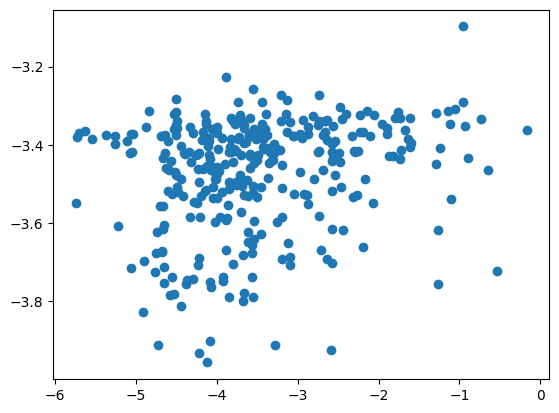

In [18]:
plt.scatter(true, pred) #, yerr=pred_std.reshape(-1,))

# Get embedding

In [10]:
loaded_model = VecLightningModule.load_from_checkpoint("lightning_logs/version_6/checkpoints/epoch=49-step=2100.ckpt")

/Users/xiaoqi/opt/anaconda3/envs/mofgraph2vec/lib/python3.8/site-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.
  rank_zero_warn(


In [ ]:
pl_model.model.eval()
params = pl_model.model.parameters()

In [ ]:
pl_model.model.embedding.weight

In [ ]:
df_vector = pd.read_csv("../data/embedding_example/embedding-dv.csv").set_index("type")

In [ ]:
vec = torch.Tensor(df_vector.loc["RSM0001"].values)

In [ ]:
embedd_vec = pl_model.model.get_embedding(vec).detach().numpy()

In [ ]:
plt.scatter(vec, embedd_vec)